In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
from joblib import Memory
%matplotlib inline

In [2]:
# Set up memory caching to avoid recomputing
memory = Memory(location='.', verbose=0)

# Load data
@memory.cache
def load_data():
    df_1 = pd.read_excel('Different rocks Data.xlsx')
    df_2 = pd.read_excel('Unique rocks Data.xlsx')
    return df_1, df_2

In [3]:
def prepare_data(df):
    X = df.drop('Log of Permeability [µm2]', axis=1)
    y = df['Log of Permeability [µm2]']
    return X, y

In [4]:
df_1, df_2 = load_data()

# Prepare data
X_1, y_1 = prepare_data(df_1)
X_2, y_2 = prepare_data(df_2)

# Split data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_1_scaled = scaler.fit_transform(X_train_1)
X_test_1_scaled = scaler.transform(X_test_1)
X_train_2_scaled = scaler.fit_transform(X_train_2)
X_test_2_scaled = scaler.transform(X_test_2)


In [5]:
# Define models and parameters for GridSearchCV
models = {
    'XGBoost': (xgb.XGBRegressor(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [3, 4],
        'learning_rate': [0.01, 0.1]
    }),
    'Linear Regression': (LinearRegression(), {}),
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    })
}

In [6]:
# Function to train and evaluate models
def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, model, params):
    try:
        grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"{model_name} - Best parameters: {grid_search.best_params_}")
        print(f"{model_name} - MSE: {mse:.4f}")
        print(f"{model_name} - R2 Score: {r2:.4f}")
        
        return best_model, y_pred, mse, r2
    except Exception as e:
        print(f"Error in {model_name}: {str(e)}")
        return None, None, None, None

In [8]:
# Plotting results
def plot_results(results):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Model Performance Comparison', fontsize=16)

    for i, (dataset_name, dataset_results) in enumerate(results.items()):
        for j, (model_name, model_results) in enumerate(dataset_results.items()):
            ax = axes[i, j]
            ax.scatter(model_results['y_pred'], y_test if i == 0 else y_test_2, alpha=0.5)
            ax.plot([y_test.min() if i == 0 else y_test_2.min(), y_test.max() if i == 0 else y_test_2.max()], 
                    [y_test.min() if i == 0 else y_test_2.min(), y_test.max() if i == 0 else y_test_2.max()], 
                    'r--', lw=2)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            ax.set_title(f'{dataset_name}\n{model_name}\nR2: {model_results["r2"]:.4f}')

    plt.tight_layout()
    plt.show()

    # Bar plot of R2 scores
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(models))
    width = 0.35

    r2_scores_1 = [results['Different Rocks'][model]['r2'] for model in models if model in results['Different Rocks']]
    r2_scores_2 = [results['Unique Rocks'][model]['r2'] for model in models if model in results['Unique Rocks']]

    ax.bar(x - width/2, r2_scores_1, width, label='Different Rocks', alpha=0.8)
    ax.bar(x + width/2, r2_scores_2, width, label='Unique Rocks', alpha=0.8)

    ax.set_ylabel('R2 Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models.keys())
    ax.legend()

    plt.tight_layout()
    plt.show()

In [7]:
# Train and evaluate models for both datasets
results = {}
for dataset_name, (X_train, X_test, y_train, y_test) in [
    ("Different Rocks", (X_train_1_scaled, X_test_1_scaled, y_train_1, y_test_1)),
    ("Unique Rocks", (X_train_2_scaled, X_test_2_scaled, y_train_2, y_test_2))
]:
    print(f"\nResults for {dataset_name}:")
    dataset_results = {}
    for model_name, (model, params) in models.items():
        best_model, y_pred, mse, r2 = train_and_evaluate(X_train, X_test, y_train, y_test, model_name, model, params)
        if best_model is not None:
            dataset_results[model_name] = {'model': best_model, 'y_pred': y_pred, 'mse': mse, 'r2': r2}
    results[dataset_name] = dataset_results



Results for Different Rocks:
XGBoost - Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
XGBoost - MSE: 2.6036
XGBoost - R2 Score: 0.5674
Linear Regression - Best parameters: {}
Linear Regression - MSE: 2.4827
Linear Regression - R2 Score: 0.5875
Random Forest - Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest - MSE: 2.6633
Random Forest - R2 Score: 0.5575

Results for Unique Rocks:
XGBoost - Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
XGBoost - MSE: 0.6548
XGBoost - R2 Score: 0.8050
Linear Regression - Best parameters: {}
Linear Regression - MSE: 0.7852
Linear Regression - R2 Score: 0.7662
Random Forest - Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest - MSE: 0.6661
Random Forest - R2 Score: 0.8016


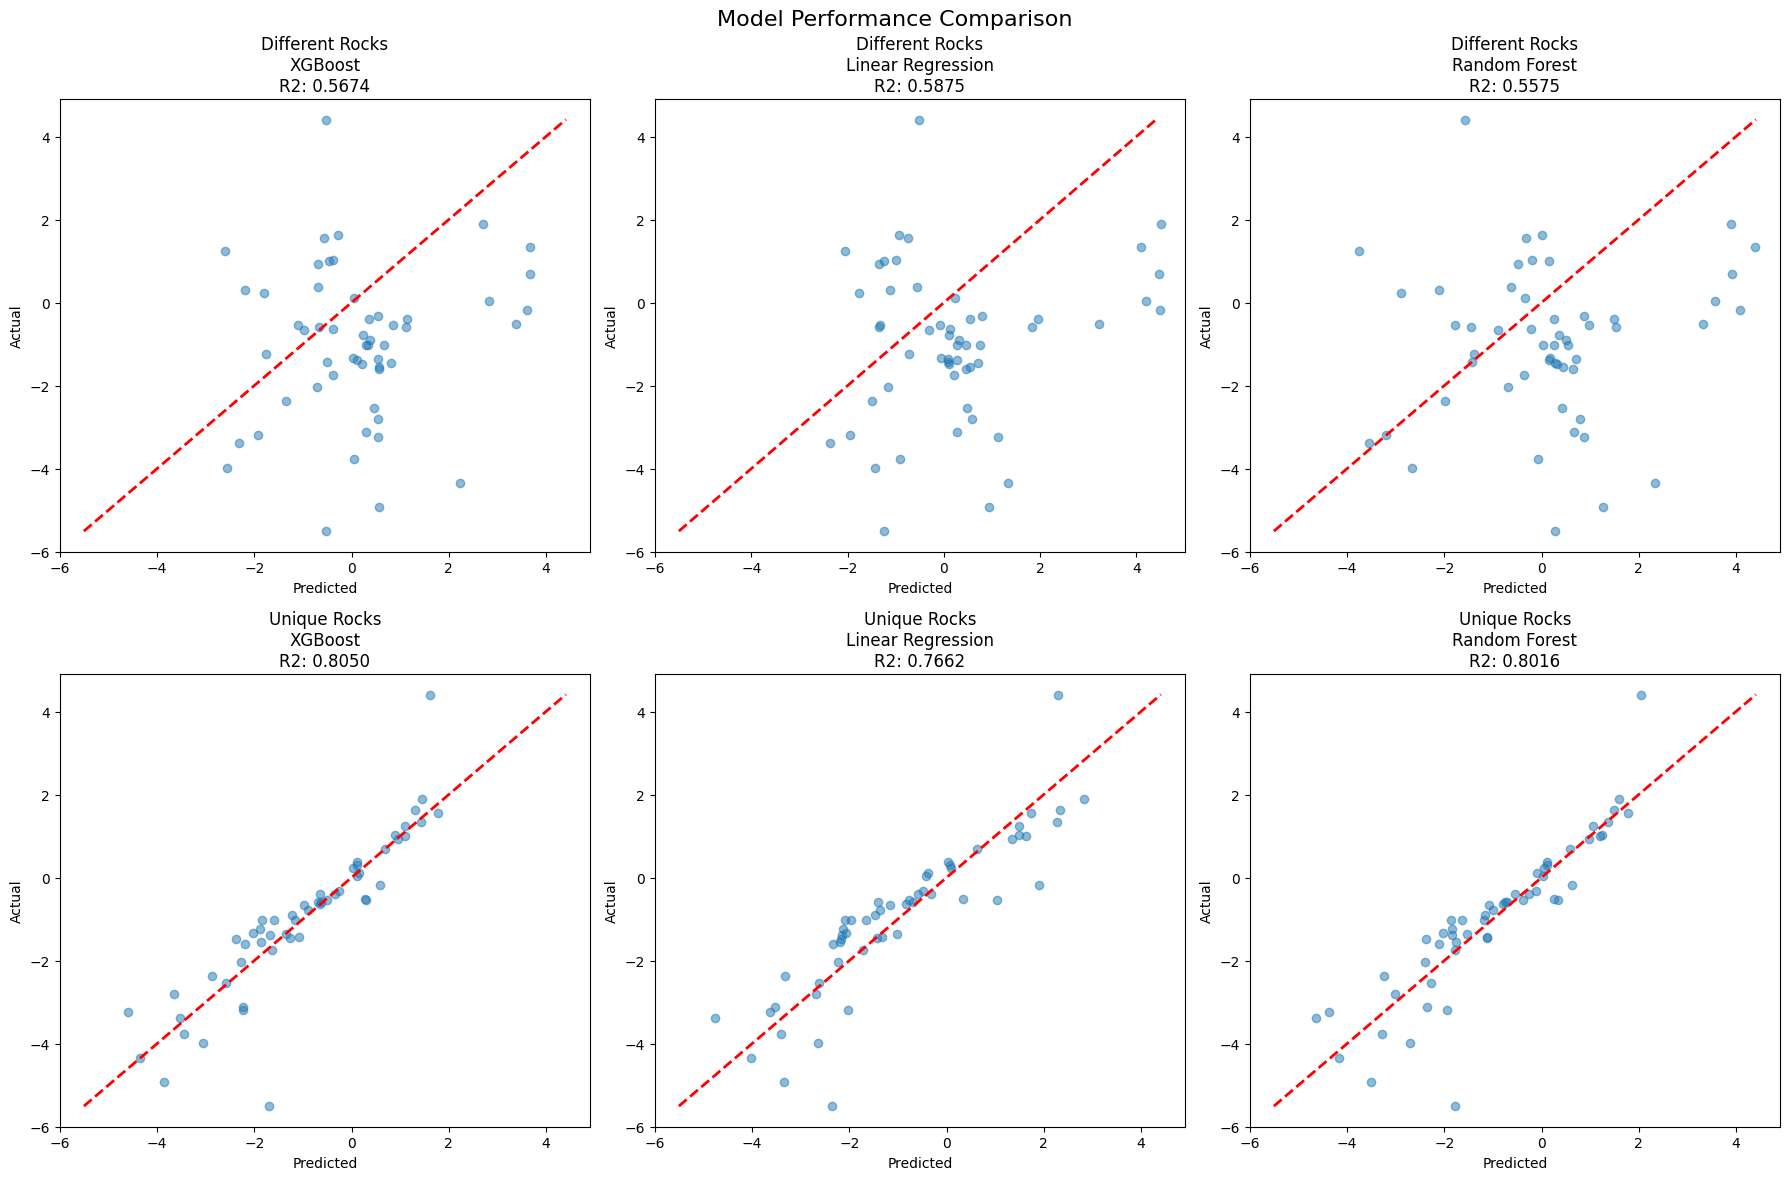

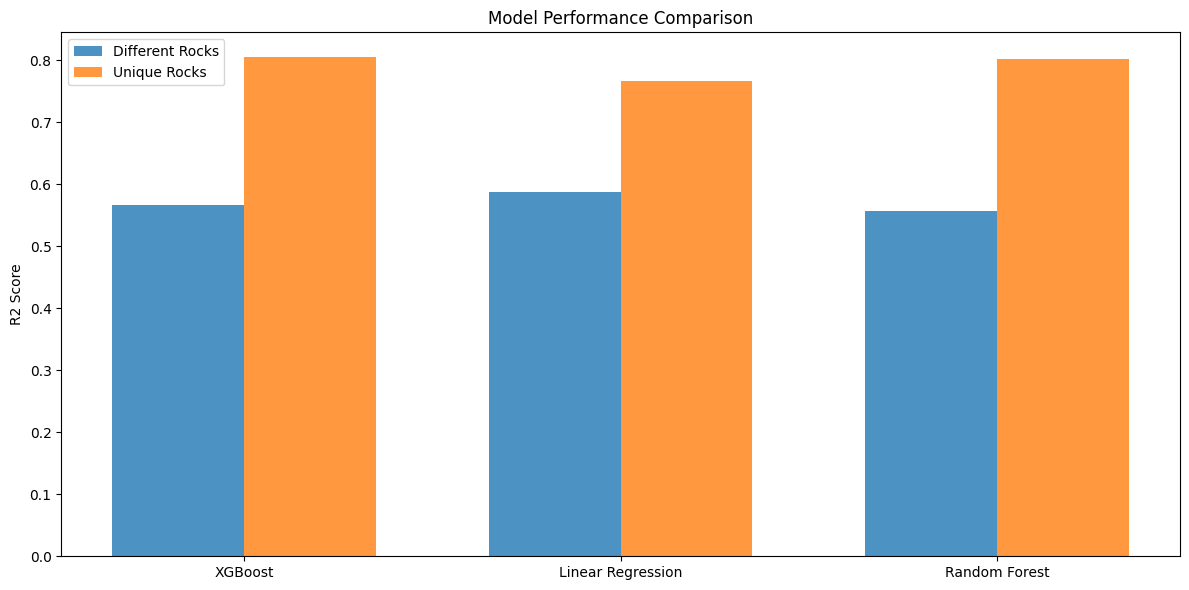

In [9]:
# Call the plotting function
plot_results(results)